# Modeling Tweets

## quality
Twitter states there is roughly 5% of spam accounts on the site. For event summarization we are not only interested in removing spam content, but also that content which exhibits a number of bad quality traits that would make a summary unclear. Therefore we try to identify the following:
* Question
* Advertisement
* Opinion
* Sarcasm
* Explicit Language or Graphic Content

Much research exists that identifies the above tasks as difficult. Therefore the expectations are our classifiers will not be that great. We take a greedy approach to summarization and accept rouch classification results due to sheer volume of data available.

An initial experiment was executed to annotate tweets on wether they contained a question, or language in first person. We analyzed this and found we can classify these tweets using an unsupervised extraction technique with high success rate. Tweets that contain first person pronouns or a question mark are not considered when creating the summary pool.

## event

#### import tools

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import nltk
from nltk import TweetTokenizer
from textblob import TextBlob
from datetime import datetime

#### import data

In [2]:
df = pd.read_table('data/final/event_indianaprimary_data.txt', sep='\t', encoding='utf-8', header=0)
df.shape

(54162, 34)

#### import ground truth

In [3]:
df_annotated = pd.read_table('data/final/cf_report_905613_Indiana200.csv', sep=',', encoding='utf-8', header=0)
df_annotated.shape

(200, 36)

#### merge ground truth with data

In [4]:
#df_annotated['question'] = df_annotated['quality'].apply(lambda q: 1 if 'question' in [i for i in str(q).split('\n')] else 0)
#df_annotated['advertisement'] = df_annotated['quality'].apply(lambda q: 1 if 'advertisement' in [i for i in str(q).split('\n')] else 0)
df_annotated['opinion'] = df_annotated['quality'].apply(lambda q: 1 if 'opinion' in [i for i in str(q).split('\n')] else 0)
#df_annotated['sarcasm'] = df_annotated['quality'].apply(lambda q: 1 if 'sarcasm' in [i for i in str(q).split('\n')] else 0)
#df_annotated['content'] = df_annotated['quality'].apply(lambda q: 1 if 'content' in [i for i in str(q).split('\n')] else 0)

In [6]:
cols = ['master_id',
        #'question',
        #'advertisement',
        'opinion',
        #'sarcasm',
        #'content',
        'update']

In [7]:
df_annotated = df_annotated[cols].fillna(0)

In [8]:
df_annotated.columns = ['master_id', 
    #'y_question',
    #'y_advertisement',
    'y_opinion',
    #'y_sarcasm',
    #'y_content',
    'y_update']

In [9]:
df = pd.merge(df, df_annotated, on='master_id')
df.shape

(200, 36)

## feature creation

#### clean text

In [10]:
#make sure to handle text as string
df['text'] = df['text'].astype('str')
#remove links
df['text_clean'] = df['text'].apply(lambda text: ' '.join([(w[:w.find('http')] if 'http' in w else w) for w in text.split()]))
#remove hashtag symbol
df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('#', ''))
#remove mention symbol
df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('@', ''))
#initiate, apply tokenization
tknzr = TweetTokenizer()
df['text_clean'] = df['text_clean'].apply(lambda s: ' '.join([w.lower() for w in tknzr.tokenize(str(s))]))

#### features
- some are pulled from existing twitter data
- some created
    - social
        - tweet
            - tweet_type
            - possibly_sensitive
            - is_retweet
            - is_reply
            - is_quoted_tweet
            - favorite_count
            - retweet_count
            - count_entities_media
            - count_entities_urls
            - count_entities_mentions
            - count_entities_hashtags
        - user
            - user_default_profile
            - user_default_profile_image
            - user_verified
            - user_statuses
            - user_favourites
            - user_followers
            - user_friends
            - user_listed
            - user_bio_len
            - user_reputation
            - user_age_days
            - user_follower_rate
    - lexical
        - count_characters
        - count_non_characters
        - count_upper
        - count_tokens
        - count_stops
        - question
        - elongation
        - ellipsis
        - lexical_diversity
        - sfpp
        - pfpp
        - pos_cnt
        - nes_cnt
        - pos_cnt_:
        - pos_cnt_DT
        - pos_cnt_JJ
        - pos_cnt_.
        - pos_cnt_EX
        - pos_cnt_PRP
        - pos_cnt_VBP
        - pos_cnt_VBZ
        - pos_cnt_,
        - pos_cnt_MD
        - pos_cnt_``
        - pos_cnt_PDT
        - pos_cnt_NNP
        - pos_cnt_NNS
        - pos_cnt_WRB
        - pos_cnt_)
        - pos_cnt_VB
        - pos_cnt_IN
        - pos_cnt_NN
        - pos_cnt_JJR
        - pos_cnt_VBG
        - pos_cnt_TO
        - pos_cnt_\$
        - pos_cnt_CC
        - pos_cnt_UH
        - pos_cnt_JJS
        - pos_cnt_RP
        - pos_cnt_CD
        - pos_cnt_PRP\$
        - pos_cnt_RBS
        - pos_cnt_SYM
        - pos_cnt_(
        - pos_cnt_WDT
        - pos_cnt_POS
        - pos_cnt_VBN
        - pos_cnt_WP
        - pos_cnt_VBD
        - pos_cnt_RB
    - semantic
        - text_sentiment_polarity
        - text_sentiment_subjectivity
        - topk_terms_coverage
        - tfidf_sum
        - tfidf_mean
        - event_centroid_distance

#### tweet features

In [115]:
df['tweet_type'] = df['tweet_type'].apply(lambda d: [0,1][d=='media']) #1=media, 0=text
df['possibly_sensitive'] = df['possibly_sensitive'].apply(lambda d: [0,1][d==True])
df['count_entities_media'] = df['entities_media'].apply(lambda media: len(media))
df['count_entities_urls'] = df['entities_urls'].apply(lambda urls: len(urls))
df['count_entities_mentions'] = df['entities_mentions'].apply(lambda mentions: len(mentions))
df['count_entities_hashtags'] = df['entities_hashtags'].apply(lambda tags: len(tags))

#### user features

In [11]:
df['user_bio_len'] = df['user_description'].apply(lambda bio: len(str(bio)))
df['user_verified'] = df['user_verified'].apply(lambda d: [0,1][d==True])
df['user_default_profile'] = df['user_default_profile'].apply(lambda d: [0,1][d==True])
df['user_default_profile_image'] = df['user_default_profile_image'].apply(lambda d: [0,1][d==True])
df['user_reputation'] = df['user_followers'] / (df['user_friends'])
df['user_reputation'].replace(np.inf, np.nan, inplace=True)
df['user_age_days'] = df['user_created_at'].apply(lambda created_at: (datetime.today() - pd.to_datetime(created_at)).days)
df['user_follower_rate'] = df['user_followers'] / df['user_age_days']
df['user_follower_rate'].replace(np.inf, np.nan, inplace=True)

#### tweet features

In [13]:
df['count_characters'] = df['text'].apply(lambda text: len(str(text)))
df['count_non_characters'] = df['text'].apply(lambda text: len(re.sub('[\w+!@#$%&;:,.?\/\-“”’`"\'()|]', '', text).strip()))
df['count_upper'] = df['text'].apply(lambda text: len([l for l in ' '.join([w for w in text.split() if not w.startswith(('#', '@'))]) if l.isupper()]))
df['count_tokens'] = df['text_clean'].apply(lambda text: len([w for w in text.split()]))
#create stop word list
stop = nltk.corpus.stopwords.words('english')
df['count_stops'] = df['text_clean'].head().apply(lambda text: len([t for t in text.split() if t in stop]))
df['question'] = df['text_clean'].apply(lambda text: 1 if '?' in text else 0)
#create elongation regular expression match
elongated = re.compile('([a-zA-Z])\\1{3,}')
df['elongation'] = df['text_clean'].apply(lambda text: 1 if bool(elongated.search(text)) else 0)
df['ellipsis'] = df['text_clean'].apply(lambda text: 1 if any(x in text for x in ('...', '…')) else 0)
df['lexical_diversity'] = df['text_clean'].apply(lambda text: len(set(text.split())) / len(text.split()))
# singular first person pronoun
sfpp = ['i', 'i\'m', 'me', 'mine', 'my', 'myself']
df['sfpp'] = df['text_clean'].apply(lambda text: 1 if any(t.lower() in sfpp for t in text.split()) else 0)
# plural first person pronoun
pfpp = ['we', 'we\'re', 'ours', 'our', 'ourselves']
df['pfpp'] = df['text_clean'].apply(lambda text: 1 if any(t.lower() in pfpp for t in text.split()) else 0)

#### event features (semantic)

In [14]:
df['text_sentiment_polarity'] = df['text_clean'].apply(lambda text: TextBlob(str(text)).sentiment.polarity)
df['text_sentiment_subjectivity'] = df['text_clean'].apply(lambda text: TextBlob(str(text)).sentiment.subjectivity)

#### terms coverage

In [15]:
#get query grams
#query_terms = df['query'].unique()
#df['query_grams_coverage'] = df['text_clean'].apply(lambda text: len([token for token in text.split() if token.lower() in query_terms]) / len(query_terms))
#compress series of tweet texts to list
tweets = [ str(d) for d in df[df['is_retweet'] == False]['text_clean']]
#extract tokens as list
tokens = [ w for t in tweets for w in t.split()]
#construct term counter
for w in [tokens]:
    termcounts = Counter(w)
#save top k = 100 most frequent terms
topk_terms = termcounts.most_common(100)
df['topk_terms_coverage'] = df['text_clean'].apply(lambda text: len([token for token in text.split() if token.lower() in topk_terms]) / len(topk_terms))

#### tfidf

In [16]:
#use only non retweets for bag of words statistics
df_nonrt = df[df['is_retweet'] == False][['master_id', 'text_clean']]
#reset index for merging with sparse matrix
df_nonrt = df_nonrt.reset_index(drop=True)
df_nonrt.shape

(200, 2)

In [17]:
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
#create matrix of tfidf counts
#not considering retweets, due to redundancy skew
Xtfidf = tfidf_vectorizer.fit_transform(df_nonrt['text_clean'])

In [18]:
#get mean tfidf for each doc
Xtfidf_means = Xtfidf.mean(axis=1)
df_tfidf_means = pd.DataFrame(Xtfidf_means, columns=['tfidf_mean'])
#get sum tfidf for each doc
Xtfidf_sums = Xtfidf.sum(axis=1)
df_tfidf_sums = pd.DataFrame(Xtfidf_sums, columns=['tfidf_sum'])

In [19]:
df_tfidf_stats = pd.concat([df_tfidf_means, df_tfidf_sums], axis=1)

In [20]:
#add tfidf sum, mean as features
df_nonrt = pd.merge(df_nonrt, df_tfidf_stats, how='inner', left_index=True, right_index=True)
#join back to full datatset
df = pd.merge(df, df_nonrt[['master_id', 'tfidf_sum', 'tfidf_mean']], how='left', on='master_id')

#### event centroid distance

In [21]:
#calculate event centroid using tfidf mean of all columns (1000 top terms)
Xtfidf_centroid = Xtfidf.mean(axis=0)

In [22]:
#compute pairwise distance for each doc to centroid using cosine similarity equation
Xtfidf_centroid_cosdistance = pairwise_distances(X=Xtfidf, Y=Xtfidf_centroid, metric='cosine')

In [23]:
df_centroid_distance = pd.DataFrame(Xtfidf_centroid_cosdistance, columns=['event_centroid_distance'])

In [24]:
#add centroid distance as feature
df_nonrt = pd.merge(df_nonrt, df_centroid_distance, how='inner', left_index=True, right_index=True)
#join back to full datatset
df = pd.merge(df, df_nonrt[['master_id', 'event_centroid_distance']], how='left', on='master_id')
#retweet centroid values are set to NaN
#because retweets will exempt from modeling

#### parts of speech, named entities
- print percent complete
- run time

In [25]:
%%time
#classify parts of speech, named entities using nltk classifier
#aggregate pos, ne counts, add counts and dictionary of parts/entities to database
#this is a slow process, should be redesigned
df_nespos = pd.DataFrame()

#define function for nltk tree mining
def getnes(tree):
    ne = []
    for node in tree:
        if type(node) is nltk.Tree:
            label = node.label()
            s = ''
            for node in node:
                s = (s + ' ' + node[0].lower()).lstrip()
            ne.append([label, s])
    return ne

complete_last = 0
for i,doc in df.iterrows():
    
    complete = round((i/df.shape[0])*100)
    if complete != complete_last:
        if complete % 2 == 0:
            print('%s%%' % complete)
            complete_last = complete
    
    tokens = nltk.word_tokenize(str(doc['text_clean']))
    
    pos = nltk.pos_tag(tokens)
    pos_cntr = Counter(list(dict(pos).values()))
    pos_data = dict(pos_cntr)
    pos_cnt = sum(pos_data.values())
    
    tree = nltk.ne_chunk(pos)
    nes = getnes(tree)
    nes_cntr = Counter(list(dict(nes).keys()))
    nes_data = dict(nes_cntr)
    nes_cnt = sum(nes_data.values())
    
    row = [pos_cnt, nes_cnt, pos_data, nes_data]
    row = pd.Series(row, index=['pos_cnt', 'nes_cnt', 'pos_data', 'nes_data'])
    row = pd.DataFrame(row).T
    df_nespos = df_nespos.append(row, ignore_index=True)
    
df = pd.merge(df, df_nespos, left_index=True, right_index=True)

2.0%
4.0%
6.0%
8.0%
10.0%
12.0%
14.0%
16.0%
18.0%
20.0%
22.0%
24.0%
26.0%
28.0%
30.0%
32.0%
34.0%
36.0%
38.0%
40.0%
42.0%
44.0%
46.0%
48.0%
50.0%
52.0%
54.0%
56.0%
58.0%
60.0%
62.0%
64.0%
66.0%
68.0%
70.0%
72.0%
74.0%
76.0%
78.0%
80.0%
82.0%
84.0%
86.0%
88.0%
90.0%
92.0%
94.0%
96.0%
98.0%
100.0%
Wall time: 35.3 s


#### convert pos counts to features
- print percent complete
- run time

In [72]:
%%time
#get all parts of speach counts, add as features
all_pos = []
for i,doc in df.iterrows():
    all_pos.extend(list(doc['pos_data'].keys()))

#get unique pos types
all_pos = list(set(all_pos))

#create pos feature df
df_pos = pd.DataFrame()
pos_cols = ['pos_cnt_'+pos for pos in all_pos] 

#update pos counts
complete_last = 0
for i,doc in df.iterrows():    
    
    complete = round((i/df.shape[0])*100)
    if complete != complete_last:
        if complete % 2 == 0:
            print('%s%%' % complete)
            complete_last = complete
    
    #create empty dictionary with keys
    pos_dict = dict.fromkeys(all_pos)
    
    for pos in doc['pos_data'].keys():
        pos_dict[pos] = doc['pos_data'].get(pos)
    
    row = list(pos_dict.values())
    row = pd.Series(row, index=pos_cols)
    row = pd.DataFrame(row).T
    df_pos = df_pos.append(row, ignore_index=True)
    
df = pd.merge(df, df_pos, left_index=True, right_index=True)

2.0%
4.0%
6.0%
8.0%
10.0%
12.0%
14.0%
16.0%
18.0%
20.0%
22.0%
24.0%
26.0%
28.0%
30.0%
32.0%
34.0%
36.0%
38.0%
40.0%
42.0%
44.0%
46.0%
48.0%
50.0%
52.0%
54.0%
56.0%
58.0%
60.0%
62.0%
64.0%
66.0%
68.0%
70.0%
72.0%
74.0%
76.0%
78.0%
80.0%
82.0%
84.0%
86.0%
88.0%
90.0%
92.0%
94.0%
96.0%
98.0%
100.0%
Wall time: 603 ms


#### convert ne counts to features
- print percent complete
- run time

In [73]:
%%time
#get all named entities counts, add as features
all_nes = []
for i,doc in df.iterrows():
    all_nes.extend(list(doc['nes_data'].keys()))

#get unique
all_nes = list(set(all_nes))

#create nes feature df
df_nes = pd.DataFrame()
ne_cols = ['ne_cnt_'+ne for ne in all_nes] 
    
#update pos counts
complete_last = 0
for i,doc in df.iterrows():    
    
    complete = round((i/df.shape[0])*100)
    if complete != complete_last:
        if complete % 2 == 0:
            print('%s%%' % complete)
            complete_last = complete
    
    #create empty dictionary with keys
    nes_dict = dict.fromkeys(all_nes)
    
    for ne in doc['nes_data'].keys():
        nes_dict[ne] = doc['nes_data'].get(ne)
    
    row = list(nes_dict.values())
    row = pd.Series(row, index=ne_cols)
    row = pd.DataFrame(row).T
    df_nes = df_nes.append(row, ignore_index=True)
    
df = pd.merge(df, df_nes, left_index=True, right_index=True)

2.0%
4.0%
6.0%
8.0%
10.0%
12.0%
14.0%
16.0%
18.0%
20.0%
22.0%
24.0%
26.0%
28.0%
30.0%
32.0%
34.0%
36.0%
38.0%
40.0%
42.0%
44.0%
46.0%
48.0%
50.0%
52.0%
54.0%
56.0%
58.0%
60.0%
62.0%
64.0%
66.0%
68.0%
70.0%
72.0%
74.0%
76.0%
78.0%
80.0%
82.0%
84.0%
86.0%
88.0%
90.0%
92.0%
94.0%
96.0%
98.0%
100.0%
Wall time: 510 ms


In [74]:
df.shape

(200, 104)

In [75]:
df.head(1)

,master_id,twitter_id,created_at,source,longitude,latitude,place_country,place_name,text,lang,...,pos_cnt_UH,pos_cnt_:,pos_cnt_JJR,pos_cnt_RBS,pos_cnt_WRB,pos_cnt_JJ,pos_cnt_CC,pos_cnt_POS,pos_cnt_CD,pos_cnt_PRP$
0,101,726929577155526657,2016-05-02 00:21:31,Twitter for Android,NaN,NaN,NaN,NaN,#IndianaPrimary..why would anyone pay $353K to...,en,...,3.0,NaN,1.0,NaN,1.0,4.0,NaN,NaN,1.0,NaN


In [129]:
features = [
 'tweet_type',
 'possibly_sensitive',
 'is_retweet',
 'is_reply',
 'is_quoted_tweet',
 'favorite_count',
 'retweet_count',
 'user_default_profile',
 'user_default_profile_image',
 'user_verified',
 'user_statuses',
 'user_favourites',
 'user_followers',
 'user_friends',
 'user_listed',
 'user_bio_len',
 'user_reputation',
 'user_age_days',
 'user_follower_rate',
 'count_entities_media',
 'count_entities_urls',
 'count_entities_mentions',
 'count_entities_hashtags',
 'count_characters',
 'count_non_characters',
 'count_upper',
 'count_tokens',
 'count_stops',
 'question',
 'elongation',
 'ellipsis',
 'lexical_diversity',
 'sfpp',
 'pfpp',
# 'text_sentiment_polarity',
# 'text_sentiment_subjectivity',
 'topk_terms_coverage',
 'tfidf_sum',
 'tfidf_mean',
 'event_centroid_distance',
 'pos_cnt',
 'nes_cnt',
 'pos_cnt_MD',
 'pos_cnt_SYM',
 'pos_cnt_(',
 'pos_cnt_$',
 'pos_cnt_,',
 'pos_cnt_WDT',
 'pos_cnt_PDT',
 'pos_cnt_JJS',
 'pos_cnt_VBD',
 'pos_cnt_RB',
 'pos_cnt_DT',
 'pos_cnt_VB',
 'pos_cnt_VBP',
 'pos_cnt_VBG',
 'pos_cnt_.',
 'pos_cnt_TO',
 'pos_cnt_EX',
 'pos_cnt_IN',
 'pos_cnt_NNP',
 'pos_cnt_VBN',
 'pos_cnt_NN',
 'pos_cnt_WP',
 'pos_cnt_RP',
 'pos_cnt_VBZ',
 'pos_cnt_``',
 'pos_cnt_)',
 'pos_cnt_NNS',
 'pos_cnt_PRP',
 'pos_cnt_UH',
 'pos_cnt_:',
 'pos_cnt_JJR',
 'pos_cnt_RBS',
 'pos_cnt_WRB',
 'pos_cnt_JJ',
 'pos_cnt_CC',
 'pos_cnt_POS',
 'pos_cnt_CD',
 'pos_cnt_PRP$']

In [79]:
ycols = [
#'y_question',
#'y_advertisement',
'y_opinion',
#'y_sarcasm',
#'y_content',
'y_update']

#### fill NaN

In [80]:
df[xcols] = df[xcols].fillna(0)

#### save data

In [116]:
#save event data with features
df.to_csv('data/final/event_indianaprimary_data_train.txt', sep='\t', encoding='utf-8', header=True, index=False)

# Modeling

In [258]:
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score

In [178]:
#import plotting library
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [83]:
df.shape

(200, 104)

#### split

In [117]:
train, test = train_test_split(df, test_size=.2)

dat = df.shape[0]
tr = len(train)
te = len(test)
print('data: %s' % dat)
print('train: %s (%s%%)' % (tr, round(100*tr/dat)))
print('test: %s (%s%%)' % (te, round(100*te/dat)))

data: 200
train: 160 (80%)
test: 40 (20%)


In [130]:
train_features = train[features]
print(train_features.shape)
test_features = test[features]
print(test_features.shape)

(160, 78)
(40, 78)


#### predict news update

In [230]:
train_update = train['y_update']
print(train_update.shape)
test_update = test['y_update']
print(test_update.shape)

(160,)
(40,)


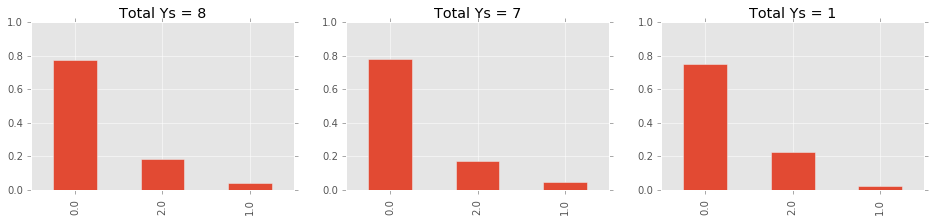

In [239]:
fig = plt.figure(figsize=(16, 3))
plt.subplot(1,3,1)
df['y_update'].value_counts(normalize=True).plot(kind='bar', ylim=(0,1), title='Total Ys = %s' % df[df['y_update']==1].shape[0])
plt.subplot(1,3,2)
train_update.value_counts(normalize=True).plot(kind='bar', ylim=(0,1), title='Total Ys = %s' % train_update[train_actual==1].shape[0])
plt.subplot(1,3,3)
test_update.value_counts(normalize=True).plot(kind='bar', ylim=(0,1), title='Total Ys = %s' % test_update[test_actual==1].shape[0])

In [280]:
#initialize report
def run_report(test_features, test_actual, model):
    #predict test data
    test_predictions = model.predict(test_features)
    #results
    print('Accuracy:', sklearn.metrics.accuracy_score(test_actual, test_predictions))
    print('Confusion Matrix: \n')
    print(pd.crosstab(test_actual, test_predictions, rownames=['Actual'], colnames=['Predicted'], margins=True))
    print()
    print('Report:')
    print(classification_report(test_actual, test_predictions))

    scores = cross_val_score(model,
                             test_features,
                             test_actual,
                             scoring='accuracy')
    print('Accuracy Scores:', scores)
    print('mean:', scores.mean())
    print('std:', scores.std())

## Naive Bayes
- Multinomial Naive Bayes significantly outperforms Gaussian model. Although Multinomial requires non-negative features, and therefore sentiment features were left out of custom feature model.

#### bag of words

In [286]:
clf_pipe = Pipeline([('count_vect', CountVectorizer()), 
                     ('X_tfidf', TfidfTransformer()), 
                     ('classifier', MultinomialNB())])

MNB_tfidf = clf_pipe.fit(train['text'], train_actual)

In [287]:
print('MNB TFIDF - Multinomial Naive Bayes using Bag of Words:')
print()
run_report(test['text'], test_update, MNB_tfidf)

MNB TFIDF - Multinomial Naive Bayes using Bag of Words:

Accuracy: 0.75
Confusion Matrix: 

Predicted  0.0  All
Actual             
0.0         30   30
1.0          1    1
2.0          9    9
All         40   40

Report:
             precision    recall  f1-score   support

        0.0       0.75      1.00      0.86        30
        1.0       0.00      0.00      0.00         1
        2.0       0.00      0.00      0.00         9

avg / total       0.56      0.75      0.64        40

Accuracy Scores: [ 0.71428571  0.76923077  0.76923077]
mean: 0.750915750916
std: 0.0259013472962


c:\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\miniconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


#### custom features

In [281]:
print('MNB - Multinomial Naive Bayes:')
print()
MNB = MultinomialNB().fit(train_features, train_update)
run_report(test_features, test_update, MNB)

MNB - Multinomial Naive Bayes:

Accuracy: 0.6
Confusion Matrix: 

Predicted  0.0  1.0  2.0  All
Actual                       
0.0         23    5    2   30
1.0          1    0    0    1
2.0          5    3    1    9
All         29    8    3   40

Report:
             precision    recall  f1-score   support

        0.0       0.79      0.77      0.78        30
        1.0       0.00      0.00      0.00         1
        2.0       0.33      0.11      0.17         9

avg / total       0.67      0.60      0.62        40

Accuracy Scores: [ 0.5         0.69230769  0.61538462]
mean: 0.602564102564
std: 0.079030948756


c:\miniconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


## K Nearest Neighbor

In [282]:
print('KNN - K Nearest Neighbor:')
print()
KNN = KNeighborsClassifier().fit(train_features, train_update)
run_report(test_features, test_update, KNN)

KNN - K Nearest Neighbor:

Accuracy: 0.775
Confusion Matrix: 

Predicted  0.0  2.0  All
Actual                  
0.0         28    2   30
1.0          1    0    1
2.0          6    3    9
All         35    5   40

Report:
             precision    recall  f1-score   support

        0.0       0.80      0.93      0.86        30
        1.0       0.00      0.00      0.00         1
        2.0       0.60      0.33      0.43         9

avg / total       0.73      0.78      0.74        40

Accuracy Scores: [ 0.71428571  0.46153846  0.76923077]
mean: 0.648351648352
std: 0.133987847313


c:\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\miniconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


## Decision Tree

In [283]:
print('DTC - Decision Tree:')
print()

DTC = DecisionTreeClassifier(random_state=2016).fit(train_features, train_update)
run_report(test_features, test_update, DTC)

DTC - Decision Tree:

Accuracy: 0.75
Confusion Matrix: 

Predicted  0.0  1.0  2.0  All
Actual                       
0.0         27    1    2   30
1.0          1    0    0    1
2.0          6    0    3    9
All         34    1    5   40

Report:
             precision    recall  f1-score   support

        0.0       0.79      0.90      0.84        30
        1.0       0.00      0.00      0.00         1
        2.0       0.60      0.33      0.43         9

avg / total       0.73      0.75      0.73        40

Accuracy Scores: [ 0.64285714  0.69230769  0.53846154]
mean: 0.624542124542
std: 0.064128723077


c:\miniconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


## Random Forest

In [284]:
print('RFC - Random Forest:')
print()
#defualt 10 trees
RFC = RandomForestClassifier(random_state=2016).fit(train_features, train_update)
run_report(test_features, test_update, RFC)

RFC - Random Forest:

Accuracy: 0.8
Confusion Matrix: 

Predicted  0.0  2.0  All
Actual                  
0.0         30    0   30
1.0          1    0    1
2.0          7    2    9
All         38    2   40

Report:
             precision    recall  f1-score   support

        0.0       0.79      1.00      0.88        30
        1.0       0.00      0.00      0.00         1
        2.0       1.00      0.22      0.36         9

avg / total       0.82      0.80      0.74        40

Accuracy Scores: [ 0.71428571  0.76923077  0.84615385]
mean: 0.776556776557
std: 0.0540836009532


c:\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\miniconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


## Support Vector Machine

In [285]:
print('SVC - Support Vector Machine:')
print()
#defualt 10 trees
SVC = svm.SVC().fit(train_features, train_update)
run_report(test_features, test_update, SVC)

SVC - Support Vector Machine:

Accuracy: 0.75
Confusion Matrix: 

Predicted  0.0  All
Actual             
0.0         30   30
1.0          1    1
2.0          9    9
All         40   40

Report:
             precision    recall  f1-score   support

        0.0       0.75      1.00      0.86        30
        1.0       0.00      0.00      0.00         1
        2.0       0.00      0.00      0.00         9

avg / total       0.56      0.75      0.64        40

Accuracy Scores: [ 0.71428571  0.76923077  0.76923077]
mean: 0.750915750916
std: 0.0259013472962


c:\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\miniconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
